In [1]:
import sys; sys.path.insert(0, '../')

import torch
import matplotlib.pyplot as plt

from gdssm.layers import Mask
from gdssm.networks_round import Encoder, Dynamics, Decoder
from gdssm.utils import wrap_mP, RounDDataset

In [2]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    device = "cuda:0"
else:
    device = "cpu"

In [3]:
path_to_data="PATH_TO_PREPROCESSED_DATA"
scenario_Ids = list(range(2,20))

dataset = RounDDataset(path_A=path_to_data, path_D=path_to_data, scenario_Ids=scenario_Ids)

# normalizing, ignore values at position (0,0)
flat_D = dataset.D.reshape(-1,2)
mask_D = (flat_D[:,0]!=0) & (flat_D[:,1]!=0)

mean = flat_D[mask_D].mean(0).unsqueeze(0)
std =  flat_D[mask_D].std(0).unsqueeze(0)

flat_D_normalized = torch.clone(flat_D)
flat_D_normalized[mask_D] = (flat_D[mask_D] - mean)/std
flat_D_normalized = flat_D_normalized.reshape(dataset.D.shape)
dataset.D = flat_D_normalized

mean = mean.to(device)
std = std.to(device)

In [12]:
mode = "full"
num_modes, D_e = 3, 4

enc = Encoder(D_e=D_e, num_modes=num_modes).to(device)
dyn = Dynamics(D_x=D_e, dt=1, mode=mode).to(device)
dec = Decoder(D_e=D_e, mode=mode).to(device)

path_enc = "PATH_TO_TRAINED_ENC"
path_dyn = "PATH_TO_TRAINED_DYN"
path_dec = "PATH_TO_TRAINED_DEC"
enc.load_state_dict(torch.load(path_enc, map_location=device), strict=False)
dyn.load_state_dict(torch.load(path_dyn, map_location=device), strict=False)
dec.load_state_dict(torch.load(path_dec, map_location=device), strict=False)

# extract entry from dataset
hist, fut, A = dataset[1337]
hist = hist.unsqueeze(0)
fut = fut.unsqueeze(0)
A = A.unsqueeze(0)

# how many vehicles are present
max_load = int((A.sum(1)>0).sum(1).max().numpy())
max_load = max(1, max_load)

# construct mask according to number valid vehicles
mask = Mask(mask_type=mode, D=D_e, num_nodes=max_load)
dyn.mask=mask

# cut out zero padded values
hist = hist[:,:max_load].to(device)
fut = fut[:,:max_load].to(device)
A = A[:, :max_load, :max_load].to(device)
batch_size, num_nodes, horizon, num_feat = fut.shape   

# encode history
m_enc, P_enc, weights = enc(hist, A)
m_enc = m_enc.reshape(batch_size*num_modes, num_nodes, D_e)
P_enc = P_enc.reshape(batch_size*num_modes, num_nodes, D_e, num_nodes, D_e)
P_enc = mask.filter_P(P_enc) # map P_enc to appropriate approximatin mode

A_batch_modes = A.unsqueeze(1).repeat(1, num_modes, 1, 1)
A_batch_modes = A_batch_modes.reshape(batch_size*num_modes, num_nodes, num_nodes)

# propagate in latent space
m_dec, P_dec = [], []
for h in range(horizon):
    if h==0:
        new_batch=True
    else:
        new_batch=False
    m_enc, P_enc = dyn.next_moments(m_enc, P_enc, A_batch_modes)       
    m_dec_, P_dec_ = dec.next_moments(m_enc, P_enc)
    m_dec.append(m_dec_), P_dec.append(P_dec_)

m_dec = torch.stack(m_dec)
P_dec = torch.stack(P_dec)

# extract for each agent a prediction
m_wrapped, P_wrapped = wrap_mP(m_dec, P_dec, mode)
m_wrapped = m_wrapped.reshape(batch_size, num_modes, horizon, num_nodes, num_feat)
P_wrapped = P_wrapped.reshape(batch_size, num_modes, horizon, num_nodes, num_feat, num_feat)

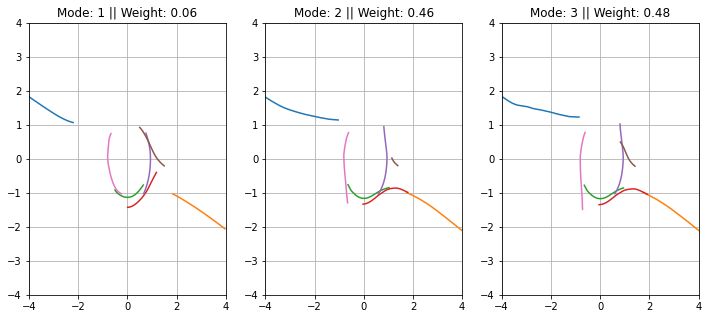

In [13]:
f, ax = plt.subplots(1,num_modes, figsize=(12,5))
for m in range(num_modes):
    for v in range(num_nodes):
        ax.flatten()[m].plot(m_wrapped[0, m, :, v,0].cpu().detach(), 
                 m_wrapped[0, m, :, v,1].cpu().detach(),
                 c="C{}".format(v))
        
    ax.flatten()[m].set_title("Mode: {} || Weight: {:.2f}".format(m+1, weights.cpu().detach().numpy()[0,m]))
    ax.flatten()[m].set_ylim(-4,4)
    ax.flatten()[m].set_xlim(-4,4)
    ax.flatten()[m].grid(True) 